**MountatinCar-v0 Review**

Goal : 가장 아래의 골짜기 시작점에서 목표지점까지 깃발 까지 가는데에 실선을 따라서 간다.

Action_Space : print(env.action_space) 출력값은

-> Discrete(3) # Down, Left, Right이다. 행동 공간, Agent가 할 수 있는 행동의 경우의 수를 의미한다. Discrete는 이산적이라는 뜻으로, 정수로 나눌 수 있다는 것을 의미한다. 해당 환경에서는 Discrete(3)으로 '왼쪽'(0), '정지'(1), '오른쪽'(2) 총 3가지 행동이 가능하다.

Observation_space : print(env.observation_space) 출력값은

-> Box(2,) 관찰 공간, Agent가 환경을 볼 수 있는 범위를 의미한다. 해당 공간에서만 정보를 얻을 수 있다. 이 관찰공간에서 low는 x축 좌표의 최솟값과, 최소 속도이다. high는 x축 좌표의 최댓값과 최대 속도를 보여준다.

render 출력은 아래의 화면처럼 나온다.



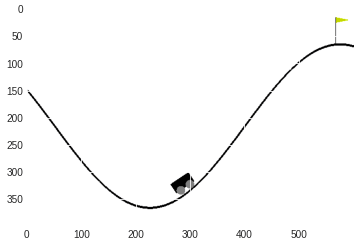

In [ ]:
!apt-get install python-opengl -y

!apt install xvfb -y

!pip install pyvirtualdisplay

!pip install piglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (662 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 144676 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 783 kB of 

In [ ]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
num_episodes = 1000
verbose = True
print_every = 100
target_avg_reward_100ep = 10
rewards = []
running_rewards = []
restore_model = True
successes = 0

gamma=0.95
epsilon=.2

In [ ]:
from pyvirtualdisplay import Display
Display().start()

import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('MountainCar-v0')
env.reset()
# img = plt.imshow(env.render('rgb_array'))

array([-0.41170899,  0.        ])

In [ ]:
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        self.num_actions = env.action_space.n
        self.state_dim = env.observation_space.shape[0]
        self.fc1 = torch.nn.Linear(self.state_dim,64,'relu')
        self.fc2 = torch.nn.Linear(64,self.num_actions,'linear')
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        y = self.fc2(x)
        return y

In [ ]:
def get_policy_values(state,policy):

    state = Variable(torch.from_numpy(state)).type(torch.FloatTensor).unsqueeze(0)
    policy_values = policy(state)
    return policy_values

In [ ]:
# Utliziado como base: https://medium.com/@ts1829/solving-mountain-car-with-q-learning-b77bf71b1de2
def generate_episode(policy,loss_fn, optimizer, successes, epsilon, gamma, t_max=1000):

    states, actions, rewards, log_probs = [], [], [], []
    state = env.reset()
    
    for t in range(t_max):
        Q = get_policy_values(state,policy)
        
        if np.random.rand() <= epsilon:
            action = random.randrange(policy.num_actions)
        else:
            _, action = torch.max(Q, -1)
            action = action.item()
            
            
       # Step forward and receive next state and reward
        state_1, reward, done, _ = env.step(action)
        
        # Adjust reward based on car position
        reward = state_1[0] + 0.5
        
        # Adjust reward for task completion
        if state_1[0] >= 0.5:
            reward += 1
            print("Solved ",done)
        
        # Find max Q for t+1 state
        Q1 = get_policy_values(state_1,policy)
        maxQ1, _ = torch.max(Q1, -1)
        
        # Create target Q value for training the policy
        Q_target = Q.clone()
        Q_target = Variable(Q_target)
        Q_target[0][action] = reward + torch.mul(maxQ1.detach(), gamma)
        
        # Calculate loss
        loss = loss_fn(Q, Q_target)
        
        # Update policy
        policy.zero_grad()
        loss.backward()
        optimizer.step()
        
        rewards.append(reward)

        if done:
            if state_1[0] >= 0.5:
                epsilon *= .9
                successes += 1
            break
        else:
            state = state_1
    return policy, loss_fn, rewards, epsilon, successes

In [ ]:
def play_episodes(policy):
    state = env.reset()
    img = plt.imshow(env.render('rgb_array')) # only call this once

    done = False
    while not done:
        img.set_data(env.render('rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        Q = get_policy_values(state,policy)
        _, action = torch.max(Q, -1)
        state,reward,done,_ = env.step(action.item())

In [ ]:
def plot_rewards(rewards, running_rewards):

    plt.style.use('seaborn-darkgrid')
    fig = plt.figure(figsize=(12,7))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    plt.subplots_adjust(hspace=.5)
    
    ax1.set_title('Episodic rewards')
    ax1.plot(rewards, label='Episodic rewards')
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel("Rewards")
    
    ax2.set_title('Running rewards')
    ax2.plot(running_rewards, label='Running rewards')
    ax2.set_xlabel("Episodes")
    ax2.set_ylabel("Average rewards")
    
    plt.show(fig)

In [ ]:
def test(policy, episode, t_max=1000):
    if episode % 100 == 0 and episode > 10:
        total_reward = []
        for i in range(10):
            state = env.reset()
            for j in range(t_max):
                Q = get_policy_values(state,policy)
                _, action = torch.max(Q, -1)
                state,reward,done,_ = env.step(action.item())
                  
                # Adjust reward based on car position
                reward = state[0] + 0.5

                # Adjust reward for task completion
                if state[0] >= 0.5:
                    reward += 1
                    print("Solved ",done)
                total_reward.append(reward)
                if done:
                    break
        ave_reward = np.mean(total_reward)
        print("Test: Episode: {}. Running reward: {}".format(episode, ave_reward))
        return ave_reward > .3
    return False

In [ ]:
def train(policy,loss_fn, optimizer, num_episodes = 1000):
    rewards = []
    running_rewards = []
    successes = 0
    epsilon = .1
    gamma=0.9
    for i in range(num_episodes):
        
        state = env.reset()
        
        policy,loss_fn,reward,epsilon,successes = generate_episode(policy,loss_fn,optimizer, successes, epsilon, gamma) 
        rewards.append(sum(reward))   
        running_reward = np.mean(reward)
        running_rewards.append(running_reward)
        
        if verbose:
            if not i % print_every:
                print("Episode: {}. Running reward: {}. Epsilon: {}".format(i+1, running_reward, epsilon))

        if test(policy, i):
            print("Ran {} episodes. Solved after {} episodes.".format(i+1, i-100+1))
            break
            
        if i == num_episodes-1 and not successes:
            print("Couldn't solve after {} episodes".format(num_episodes))
            
    print('successful episodes: {:d} - {:.4f}%'.format(successes, successes/num_episodes*100))
    return rewards, running_rewards

#### Treinamento da shallow learning

In [ ]:
verbose = True
print_every = 100
running_reward = None
rewards = []
running_rewards = []
restore_model = True

In [ ]:
print("shallow learning")
state = env.reset()
policy = Policy()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(policy.parameters(), lr=0.001)
rewards,running_rewards = train(policy, loss_fn, optimizer, num_episodes=1000)

shallow learning
Episode: 1. Running reward: -0.0536160044855608. Epsilon: 0.1
Solved  True
Episode: 101. Running reward: 0.10352306360040955. Epsilon: 0.09000000000000001
Test: Episode: 100. Running reward: 0.12522757899942188
Episode: 201. Running reward: 0.11075276681966979. Epsilon: 0.09000000000000001
Test: Episode: 200. Running reward: 0.12076462999422503
Episode: 301. Running reward: 0.11449979089424492. Epsilon: 0.09000000000000001
Test: Episode: 300. Running reward: 0.12526351446785025
Episode: 401. Running reward: 0.10174689683598252. Epsilon: 0.09000000000000001
Test: Episode: 400. Running reward: 0.12488883782752216
Episode: 501. Running reward: 0.10836422734065185. Epsilon: 0.09000000000000001
Test: Episode: 500. Running reward: 0.12336245072082576
Episode: 601. Running reward: 0.09854193096077526. Epsilon: 0.09000000000000001
Test: Episode: 600. Running reward: 0.12361794378359393
Episode: 701. Running reward: 0.11176632621948006. Epsilon: 0.09000000000000001
Test: Episod

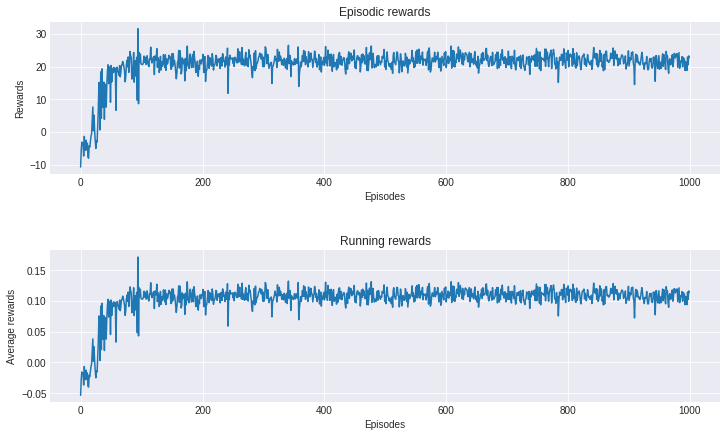

In [ ]:
plot_rewards(rewards, running_rewards)

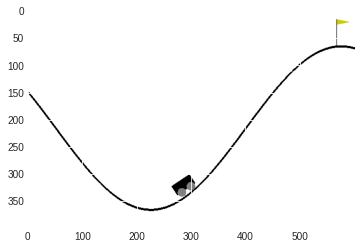

In [ ]:
play_episodes(policy)

In [ ]:
print(env.observation_space)
print(env.action_space)

Box(2,)
Discrete(3)
